/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


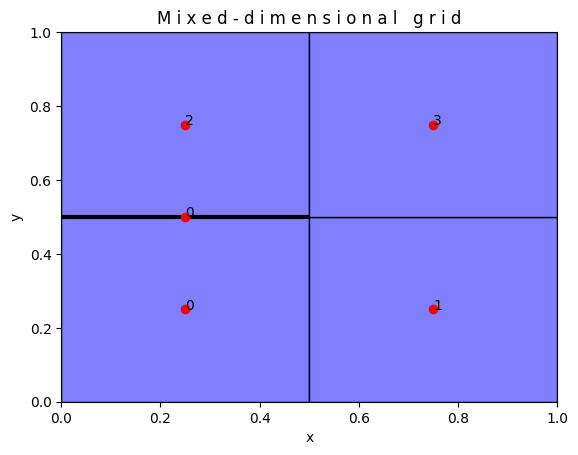

In [1]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from one_cell_setup import make_model
from pp_utils import make_row_col_dofs, make_reorder_contact
from pp_utils import correct_eq_groups


model = make_model()
model.prepare_simulation()
model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)
reorder = make_reorder_contact(model)
corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)

pp.plot_grid(
    model.mdg,
    plot_2d=True,
    fracturewidth_1d=3,
    rgb=[0.5, 0.5, 1],
    info='C',
)

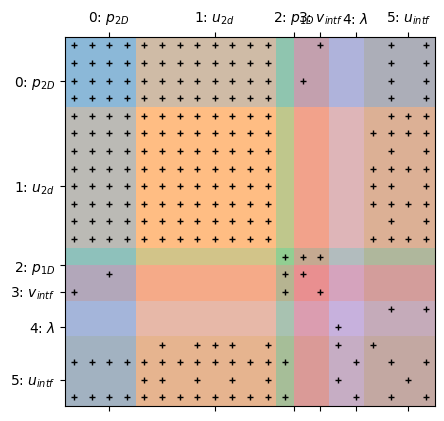

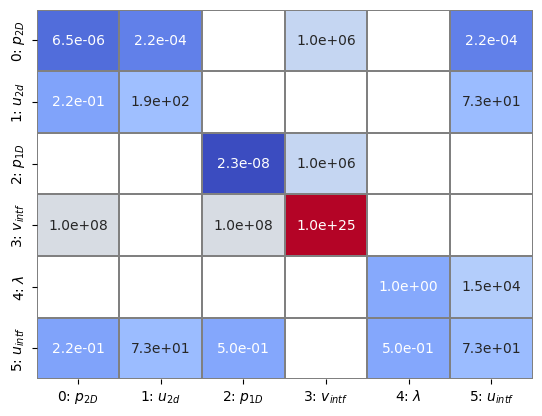

In [2]:
from block_matrix import BlockMatrixStorage


def build_S44(J: BlockMatrixStorage):
    return - J[4, 5].mat @ inv(J[5,5].mat) @ J[5, 4].mat

def make_matrix_rhs():
    model.before_nonlinear_loop()
    model.before_nonlinear_iteration()
    model.assemble_linear_system()
    mat, rhs = model.linear_system
    mat = mat[reorder]

    J = BlockMatrixStorage(
        mat=mat,
        global_row_idx=corrected_eq_dofs,
        global_col_idx=model.var_dofs,
        groups_row=corrected_eq_groups,
        groups_col=model._variable_groups,
        group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
        group_col_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']
    )
    return J, rhs

def characteristic():
    return model._characteristic.value(model.equation_system).astype(bool)

J, rhs = make_matrix_rhs()

J[:].color_spy()
J[:].plot_max()

[False] [False] [ True]


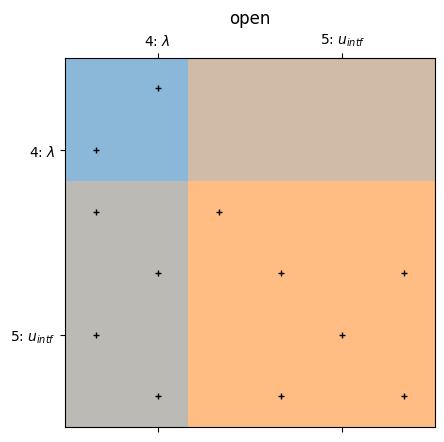

In [3]:
def make_open():
    lambdas = model.equation_system.get_variable_values(variables=[model.contact_traction_variable], iterate_index=0)
    lambdas[:] = 0
    u_intf = model.equation_system.get_variable_values(variables=[model.interface_displacement_variable], iterate_index=0)
    u_intf[:] = 0

    lambdas[0] = 0
    lambdas[1] = 100
    # u_intf[1] = -100

    model.equation_system.set_variable_values(lambdas, variables=[model.contact_traction_variable], iterate_index=0)
    model.equation_system.set_variable_values(u_intf, variables=[model.interface_displacement_variable], iterate_index=0)

    J, rhs = make_matrix_rhs()

    sticking, sliding, open_ = model.sticking_sliding_open()
    print(sticking, sliding, open_)
    assert np.all(open_)

    return J


J = make_open()
plt.title('open')
J[[4, 5]].color_spy()
# J[[4]].matshow()

In [4]:
S44 = build_S44(J)
S44.A

array([[0., 0.],
       [0., 0.]])

[ True] [False] [False]


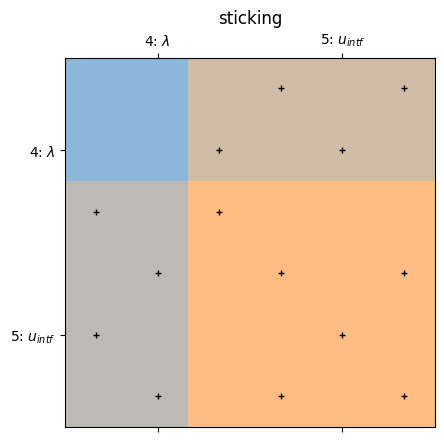

In [5]:
def make_sticking():
    lambdas = model.equation_system.get_variable_values(variables=[model.contact_traction_variable], iterate_index=0)
    lambdas[:] = 0
    u_intf = model.equation_system.get_variable_values(variables=[model.interface_displacement_variable], iterate_index=0)
    u_intf[:] = 0

    lambdas[0] = 0
    lambdas[1] = -100
    # u_intf[1] = -100

    model.equation_system.set_variable_values(lambdas, variables=[model.contact_traction_variable], iterate_index=0)
    model.equation_system.set_variable_values(u_intf, variables=[model.interface_displacement_variable], iterate_index=0)

    # u_intf[0] = 0.0005
    # model.equation_system.set_variable_values(u_intf, variables=[model.interface_displacement_variable], time_step_index=0)

    J, rhs = make_matrix_rhs()

    sticking, sliding, open_ = model.sticking_sliding_open()
    print(sticking, sliding, open_)
    
    assert np.all(sticking)

    char = characteristic()
    assert not np.any(char)

    return J


J = make_sticking()
plt.title('sticking')
J[[4, 5]].color_spy()
# J[[4]].matshow()

# Reproduce J45

In [6]:
J[4, 5].mat.A

array([[      0.     ,  -14854.72195,       0.     ,   14854.72195],
       [-891283.317  ,       0.     ,  891283.317  ,       0.     ]])

In [7]:
# Tangential part
frac = model.mdg.subdomains(dim=1)
c = model.contact_mechanics_numerical_constant(frac)
b = model.friction_bound(frac)
(c * b).value(model.equation_system)

array([891283.317])

In [8]:
c = model.contact_mechanics_numerical_constant(frac)
(-c).value(model.equation_system)

-14854.72195

In [9]:
nd_vec_to_tangential = model.tangential_component(frac)
proj = nd_vec_to_tangential.value(model.equation_system)
proj.A

array([[1., 0.]])

# Reproduce J55

In [10]:
J55 = J[5, 5].mat
# plot_mat(J55, log=True)
J55.diagonal()

array([29.7094439 , 72.78329726, 29.7094439 , 72.78329726])

In [11]:
mu = model.solid.shear_modulus()
lamda = model.solid.lame_lambda()
stiffness = 2 * mu + lamda
stiffness

36.730270006

In [12]:
matrix = model.mdg.subdomains(dim=2)[0]

intf = model.mdg.interfaces()[0]
idx_0, idx_1 = intf.mortar_to_primary_int().indices
idx_0, idx_1 = matrix.cell_faces.T.tocsc()[:, [idx_0, idx_1]].indices
h = (matrix.cell_diameters() / 2)[[idx_0, idx_1]]
print(h)
h = h.mean()

[0.35355339 0.35355339]


In [13]:
normal = stiffness / h
tangential = stiffness / (2 * h)

tangential, normal

(51.9444459921109, 103.8888919842218)

# Reproduce J54

In [14]:
J[5, 4].mat.data

array([-0.5,  0.5,  0.5, -0.5])

In [15]:
intf.cell_volumes

array([0.5, 0.5])

In [16]:
J55_binv = inv_block_diag(J[5, 5].mat, nd=model.nd)
J

BlockMatrixStorage of shape (21, 21) with 239 elements

In [18]:
S44 = build_S44(J)
S44.A

array([[     0.        ,    204.07769967],
       [-30000.        ,      0.        ]])

[ True] [False] [False]


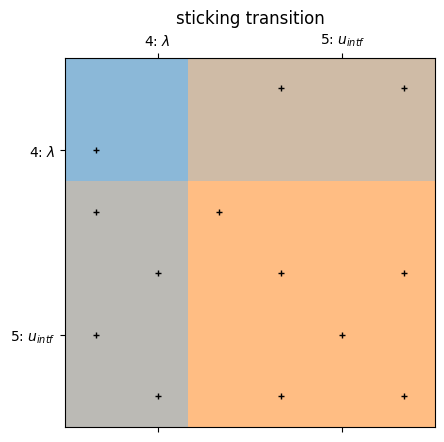

In [19]:
def make_sticking_transition():
    lambdas = np.zeros(2)
    u_intf = np.zeros(4)

    lambdas[0] = 0
    lambdas[1] = -1e-6

    model.equation_system.set_variable_values(lambdas, variables=[model.contact_traction_variable], iterate_index=0)
    model.equation_system.set_variable_values(u_intf, variables=[model.interface_displacement_variable], iterate_index=0)
    J, rhs = make_matrix_rhs()

    sticking, sliding, open_ = model.sticking_sliding_open()
    print(sticking, sliding, open_)
    
    assert np.all(sticking)

    char = characteristic()
    assert np.all(char)

    return J


J = make_sticking_transition()
plt.title('sticking transition')
J[[4, 5]].color_spy()
# J[[4]].matshow()

In [20]:
S44 = build_S44(J)
S44.A

array([[  0.        , 204.07769967],
       [  0.        ,   0.        ]])

In [21]:
frac = model.mdg.subdomains(dim=1)
lambda_n = model.normal_component(frac) @ model.contact_traction(frac)
print('lambda_n', lambda_n.value(model.equation_system))

lambda_tau = model.tangential_component(frac) @ model.contact_traction(frac)
print('lambda_tau', lambda_tau.value(model.equation_system))

lambda_n [-1.e-06]
lambda_tau [0.]


[False] [ True] [False]


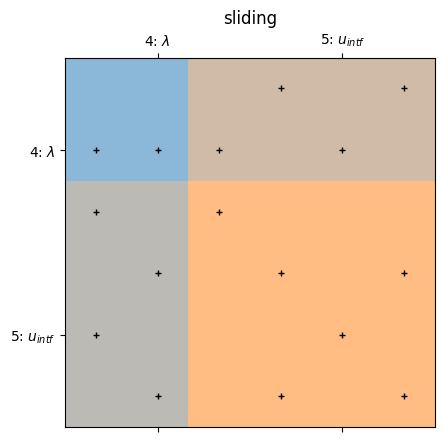

In [22]:
def make_sliding():
    lambdas = np.zeros(2)
    u_intf = np.zeros(4)

    lambdas[0] = -100
    lambdas[1] = -100
    # u_intf[1] = -100

    model.equation_system.set_variable_values(lambdas, variables=[model.contact_traction_variable], iterate_index=0)
    model.equation_system.set_variable_values(u_intf, variables=[model.interface_displacement_variable], iterate_index=0)
    J, rhs = make_matrix_rhs()

    sticking, sliding, open_ = model.sticking_sliding_open()
    print(sticking, sliding, open_)
    
    assert np.all(sliding)

    char = characteristic()
    assert not np.any(char)

    return J


J = make_sliding()
plt.title('sliding')
J[[4, 5]].color_spy()
# J[[4]].matshow()

In [23]:
S44 = build_S44(J)
S44.A

array([[    0.        ,   204.07769967],
       [20000.        ,     0.        ]])

[False] [ True] [False]


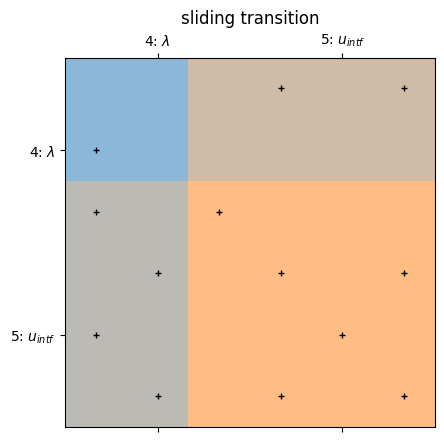

In [24]:
def make_sliding_transition():
    lambdas = np.zeros(2)
    u_intf = np.zeros(4)

    lambdas[0] = -1e-6
    lambdas[1] = -1e-6
    # u_intf[1] = -100

    model.equation_system.set_variable_values(lambdas, variables=[model.contact_traction_variable], iterate_index=0)
    model.equation_system.set_variable_values(u_intf, variables=[model.interface_displacement_variable], iterate_index=0)
    J, rhs = make_matrix_rhs()

    sticking, sliding, open_ = model.sticking_sliding_open()
    print(sticking, sliding, open_)
    
    assert np.all(sliding)

    char = characteristic()
    assert np.all(char)

    return J


J = make_sliding_transition()
plt.title('sliding transition')
J[[4, 5]].color_spy()
# J[[4]].matshow()

In [25]:
S44 = build_S44(J)
S44.A

array([[  0.        , 204.07769967],
       [  0.        ,   0.        ]])